In [1]:
import os
import gzip
import pandas as pd
import matplotlib.pyplot as plt

## 1. Load data

* **Source**: [Chitanka Rechnik](https://rechnik.chitanka.info/)

In [2]:
# Read the csv file in the gzip archive
words_df = pd.read_csv('data/1_chitanka_words.csv.gz', encoding='windows-1251', compression='gzip')
words_df.index.name = 'id'
words_df['is_main'] = words_df['is_main'].astype(bool) # Convert to boolean
words_df.head()

,word,is_main,search_count,description
id,,,,
0,аванпост,True,0,ед.ч.
1,аванпоста,False,42,ед.ч. непълен член
2,аванпостът,False,33,ед.ч. пълен член
3,аванпостове,False,46,мн.ч.
4,аванпостовете,False,31,мн.ч. членувано


In [3]:
print(f"Total words count: {len(words_df):,}")
words_df.dtypes

Total words count: 4,013,667


word            object
is_main           bool
search_count     int64
description     object
dtype: object

## 2. Remove spaced words
In our final vocabulary we don't need compound words like:
* `ще играя` - this should be split into two words

In [4]:
spaced_words = words_df[words_df['word'].str.contains(" ")]
print(f"Number of spaced words: {len(spaced_words):,}")
spaced_words.sample(10)

Number of spaced words: 2,546,591


,word,is_main,search_count,description
id,,,,
609117,щял е да е зеленясвал,False,4,"пр.накл., бъд.пред.вр., 3л., ед.ч., м.р."
2441494,щяла е да е споразумявала,False,4,"пр.накл., бъд.пред.вр., 3л., ед.ч., ж.р."
1493725,бил съм окаишвал,False,2,"пр.накл., мин.неопр.вр., 1л., ед.ч., м.р."
3217239,убедила съм,False,0,"пр.накл., мин.св.вр., 1л., ед.ч., ж.р."
3920699,засипала си,False,9,"мин.неопр.вр., 2л., ед.ч., ж.р."
2378571,било си преслушало,False,3,"пр.накл., мин.неопр.вр., 2л., ед.ч., ср.р."
2794575,бил упрекнал,False,4,"пр.накл., мин.неопр.вр., 3л., ед.ч., м.р."
2056282,беше смушквала,False,10,"мин.пред.вр., 2л., ед.ч., ж.р."
2829315,бяха важничили,False,7,"мин.пред.вр., 3л., мн.ч."


So, let's directly remove them from the base dataframe.

In [5]:
# Remove words with spaces
words_df = words_df[~words_df['word'].str.contains(" ")]
print(f"Total words count (after spaced-words removal): {len(words_df):,}")

Total words count (after spaced-words removal): 1,467,076


## 3. Add spaced word parts

Meanwhile, we should check if there is still any value in the removed words. We will split them by space and check if the generated parts exists in the vocabulary. If not, then we'll add them.

In [6]:
# Split the words into parts and keep them as a set.
spaced_words_parts = spaced_words['word'].str.split(" ")
# Flatten the list and convert it to a set (no duplicates)
spaced_words_parts = set([part for parts in spaced_words_parts for part in parts])
# Print the number of unique parts
print(f"Number of unique parts: {len(spaced_words_parts):,}")
# Print the parts
print(list(spaced_words_parts)[:10])

Number of unique parts: 199,017
['дооздравееш', 'кашлят', 'схокал', 'тормози', 'спомнела', 'замечтаваме', 'пораждате', 'гориш', 'сподавяме', 'поразмазало']


Check if any of the separated words need to be added to the vocabulary.

In [7]:
words_set = set(words_df['word'].values)
spaced_parts_diff = set(spaced_words_parts) - words_set
print(f"Number of missing parts: {len(spaced_parts_diff):,}")
print(sorted(spaced_parts_diff))

Number of missing parts: 12
['беше', 'бях', 'бяха', 'бяхме', 'бяхте', 'да', 'е', 'са', 'се', 'сме', 'сте', 'съм']


Twelve words can be added to the vocabulary. We don't have information about their `description`, `is_main` and `search count`, so we'll set them to `NaN`.

In [8]:
# Insert the missing parts into the words_df
words_df = pd.concat([words_df, pd.DataFrame({'word': list(spaced_parts_diff)})])

print(f"Total words count (after inserting missing parts): {len(words_df):,}")

words_df[words_df['word'].isin(spaced_parts_diff)].head(12)

Total words count (after inserting missing parts): 1,467,088


,word,is_main,search_count,description
0,да,NaN,NaN,NaN
1,е,NaN,NaN,NaN
2,сте,NaN,NaN,NaN
3,бях,NaN,NaN,NaN
4,бяхте,NaN,NaN,NaN
5,съм,NaN,NaN,NaN
6,бяхме,NaN,NaN,NaN
7,са,NaN,NaN,NaN
8,сме,NaN,NaN,NaN
9,се,NaN,NaN,NaN


## 4. Remove dashed words
Now, we repeat the same, but with dashed words (we want them split and the parts treated like separate words).
* `художествено-музикален` - this should be split into two words

In [9]:
dashed_words = words_df[words_df['word'].str.contains("-")]
print(f"Number of dashed words: {len(dashed_words):,}")
dashed_words.sample(10)

Number of dashed words: 11,028


,word,is_main,search_count,description
188975,тактико-технически,True,0.0,м.р.
43465,контролно-ревизионно,False,5.0,ср.р.
356626,сиво-розов,True,0.0,м.р.
497828,заместник-комисари,False,15.0,мн.ч.
163374,гръцко-холандската,False,3.0,ж.р. членувано
489039,кандидат-първолака,False,13.0,ед.ч. непълен член
440172,кандидат-новодомците,False,8.0,мн.ч. членувано
384692,инженер-агрономи,False,0.0,бройна форма
75252,приходно-разходната,False,9.0,ж.р. членувано
267955,помощник-инженерче,True,0.0,ед.ч.


In [10]:
# Remove words with spaces
words_df = words_df[~words_df['word'].str.contains("-")]
print(f"Total words count (after dashed words removal): {len(words_df):,}")

Total words count (after dashed words removal): 1,456,060


## 5. Add dashed word parts

In [11]:
# Split the words into parts and keep them as a set.
dashed_words_parts = dashed_words['word'].str.split("-")
# Flatten the list and convert to set (no duplicates)
dashed_words_parts = set([part for parts in dashed_words_parts for part in parts])
# Print the number of unique parts
print(f"Number of unique parts: {len(dashed_words_parts):,}")
# Print the parts
print(list(dashed_words_parts)[:10])

Number of unique parts: 6,295
['черен', 'брокерското', 'костно', 'лесомелиоративните', 'инструментални', 'командното', 'лирико', 'центристки', 'математическия', 'милионерчетата']


In [12]:
# Identify missing words, that could be added to the words_df set
words_set = set(words_df['word'].values)
dashed_parts_diff = set(dashed_words_parts) - words_set
print(f"Number of missing parts: {len(dashed_parts_diff):,}")
print(sorted(dashed_parts_diff))

Number of missing parts: 324
['154', 'C', 'G', 'S', 'Австро', 'Г', 'До', 'Дота', 'Дотата', 'Дото', 'Илинденско', 'МВР', 'П', 'Преображенска', 'Преображенската', 'Преображенски', 'Преображенските', 'Преображенския', 'Преображенският', 'Преображенско', 'Преображенското', 'Рило', 'Родопска', 'Родопската', 'Родопски', 'Родопските', 'Родопския', 'Родопският', 'Родопско', 'Родопското', 'Ройс', 'Ройса', 'Ройси', 'Ройсите', 'Ройсче', 'Ройсчета', 'Ройсчетата', 'Ройсчето', 'Ройсът', 'Ролс', 'ТаеКуон', 'Ту', 'Унгария', 'Унгарията', 'а', 'австро', 'авто', 'агро', 'актрисо', 'актьоре', 'акушеро', 'алъш', 'американо', 'англо', 'армено', 'асиро', 'биджи', 'биджита', 'биджитата', 'биджито', 'бо', 'бото', 'булко', 'бутанче', 'бутанчета', 'бутанчетата', 'бутанчето', 'българо', 'велочасти', 'велочастите', 'венеричен', 'венерична', 'венеричната', 'венерични', 'венеричните', 'венеричния', 'венеричният', 'венерично', 'венеричното', 'вериш', 'вериша', 'вериши', 'веришите', 'веришче', 'веришчета', 'веришчетат

There are several invalid Bulgarian words, that we'll skip (`G`, `Г`, `промишлният`, `художествния` ...)

In [13]:
# Remove words that are not valid Bulgarian words
dashed_parts_diff = set(dashed_parts_diff) - set(['154', 'G', 'C', 'S', 'Г', 'П', 'такът', 'таци', 'таците', 'художествния', 'художествното', 'художествните', 'художествно', 'художествна', 'художествният', 'художествни', 'художествната', 'промишлният', 'промишлната', 'промишлно', 'промишлни', 'промишлните', 'промишлна', 'промишлното', 'промишлния'])
# Insert the missing parts into the words_df
words_df = pd.concat([words_df, pd.DataFrame({'word': list(dashed_parts_diff)})])
# Print the new size
print(f"Total words count (after inserting missing parts): {len(words_df):,}")
# Print some of the new words
words_df[words_df['word'].isin(dashed_parts_diff)].head(15)

Total words count (after inserting missing parts): 1,456,359


,word,is_main,search_count,description
0,хопърче,NaN,NaN,NaN
1,англо,NaN,NaN,NaN
2,лесомелиоративни,NaN,NaN,NaN
3,контузно,NaN,NaN,NaN
4,изпълнителке,NaN,NaN,NaN
5,перпетуум,NaN,NaN,NaN
6,проспектовият,NaN,NaN,NaN
7,мазаческият,NaN,NaN,NaN
8,лесомелиоративните,NaN,NaN,NaN
9,ноу,NaN,NaN,NaN


## 6. Remove capitalized words (names)

We want to keep our `vocabulary` free of names. Names could be gathered in a separate list.

In [14]:
# Extract all names that start with a capital letter
names_df = words_df[words_df['word'].str.match(r'^[А-Я]')]
print(f"Number of names: {len(names_df):,}")
print(names_df.word.unique().tolist())

Number of names: 5,295
['ДОС', 'ДОСа', 'ДОСът', 'ДОСове', 'ДОСовете', 'Евроспорт', 'Евроспорта', 'Евроспортът', 'Евроспортове', 'Евроспортовете', 'Райх', 'Райха', 'Райхът', 'Райхове', 'Райховете', 'ТЕЛК', 'ТЕЛКа', 'ТЕЛКът', 'ТЕЛКове', 'ТЕЛКовете', 'Каризма', 'Каризмата', 'Сорбона', 'Сорбоната', 'Британика', 'Британиката', 'Британики', 'Британиките', 'Бундеслига', 'Бундеслигата', 'Бундеслиги', 'Бундеслигите', 'Винариа', 'Винариата', 'Винарии', 'Винариите', 'Евроконституцийка', 'Евроконституцийката', 'Евроконституцийки', 'Евроконституцийките', 'Евролевица', 'Евролевицата', 'Евролевици', 'Евролевиците', 'Европа', 'Европата', 'Европи', 'Европите', 'Клаусура', 'Клаусурата', 'Клаусури', 'Клаусурите', 'Коледа', 'Коледата', 'Коледи', 'Коледите', 'Марсилеза', 'Марсилезата', 'Марсилези', 'Марсилезите', 'Ривиера', 'Ривиерата', 'Ривиери', 'Ривиерите', 'Скудерийка', 'Скудерийката', 'Скудерийки', 'Скудерийките', 'Токуда', 'Токудата', 'Токуди', 'Токудите', 'Ханука', 'Хануката', 'Хануки', 'Хануките', 

In [15]:
# Remove words that start with a capital letter
words_df = words_df[~words_df['word'].str.match(r'^[А-Я]')]
print(f"Total words count (after removing names): {len(words_df):,}")

Total words count (after removing names): 1,451,064


## 7. Length distribution

* **OBSERVATION**: We observe a skewed normal distribution, which is expected.

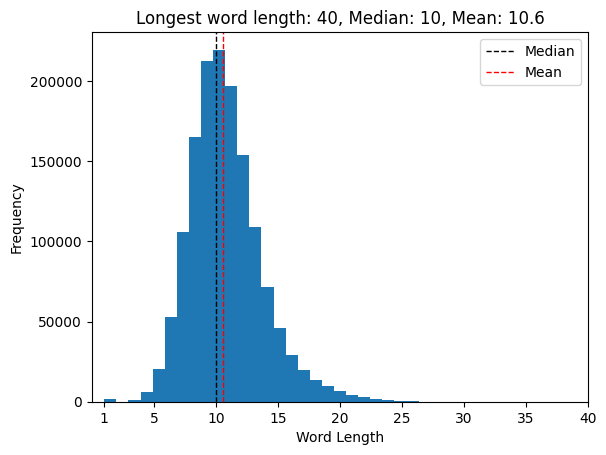

In [16]:
# Plot the distribution of the words by length
def plot_word_lengths(words_df):
    word_lengths = words_df['word'].str.len()
    mean_length = word_lengths.mean()
    median_length = word_lengths.median()
    word_longest = word_lengths.max()
    plt.hist(word_lengths, bins=word_longest)
    plt.axvline(median_length, color='black', linestyle='dashed', linewidth=1)
    plt.axvline(mean_length, color='red', linestyle='dashed', linewidth=1)
    plt.legend(['Median', 'Mean'])
    plt.xlabel('Word Length')
    plt.ylabel('Frequency')
    plt.title(f'Longest word length: {word_longest}, Median: {median_length:.0f}, Mean: {mean_length:.1f}')
    plt.xticks([1, 5, 10, 15, 20, 25, 30, 35, 40])
    plt.xlim(0, 40)
    plt.show()

plot_word_lengths(words_df)

Hmm, there is a spike in the one-letter words. I expected to see no more than 30. :)

## 8. Check 1-letter words

In [17]:
# One letter words
one_letter_words = words_df[words_df['word'].str.len() == 1]
print(f"Number of one letter words: {len(one_letter_words):,}")
one_letter_words.sample(5)

Number of one letter words: 1,454


,word,is_main,search_count,description
4004772,—,False,0.0,мъжка форма
4004864,—,False,0.0,мъжка форма
3999495,—,False,0.0,"м.р., ед.ч., непълен член"
4004119,—,False,0.0,женска форма
3999636,—,False,0.0,"м.р., ед.ч., пълен член"


## 9. Remove invalid 1-letter words
These are invalid words. We need to remove them.

In [18]:
# Remove words that are equal to '—'
print(f"Number of words to be removed: {len(words_df[words_df['word'] == '—']):,}")
words_df = words_df[words_df['word'] != '—']
print(f"Total words count (after removing '—'): {len(words_df):,}")

Number of words to be removed: 1,449
Total words count (after removing '—'): 1,449,615


Let's which are the one-letter words left.

In [19]:
# One letter words
one_letter_words = words_df[words_df['word'].str.len() == 1]
one_letter_words.head()

,word,is_main,search_count,description
3998299,я,False,0.0,"винителен падеж, кратка форма"
3998302,и,False,0.0,"дателен падеж, кратка форма"
3998424,и,False,0.0,кратка форма
1,е,NaN,NaN,NaN
135,а,NaN,NaN,NaN


* **OBSERVATION**: I can see some 1-letter words missing: `в`, `о`, `с`, `у`. Let's add them.
* **OBSERVATION**: I can also see a duplicated word `и` (the description is different, but we have to produce a flat list of words in the end, so no need of duplicates)

## 10. Add 1-letter words

In [20]:
words_df = pd.concat([words_df, pd.DataFrame({'word': ['в', 'о', 'с', 'у']})])
print(f"Total words count (after adding 1-letter words): {len(words_df):,}")

Total words count (after adding 1-letter words): 1,449,619


## 11. Check 2-letter words

In [21]:
# Two letter words
two_letter_words = words_df[words_df['word'].str.len() == 2]
print(f"Number of two letter words: {len(two_letter_words):,}")
print(sorted(two_letter_words['word'].tolist()))

Number of two letter words: 94
['ад', 'аз', 'ар', 'ас', 'ат', 'би', 'би', 'би', 'би', 'бо', 'ви', 'ви', 'ви', 'ви', 'ви', 'вя', 'вя', 'вя', 'вя', 'ги', 'го', 'го', 'да', 'ду', 'ду', 'еж', 'ек', 'еш', 'зя', 'зя', 'им', 'им', 'ку', 'ля', 'ля', 'ля', 'ля', 'ме', 'ми', 'ми', 'ми', 'ми', 'му', 'му', 'му', 'ни', 'ни', 'ни', 'ом', 'ос', 'пи', 'пи', 'пя', 'пя', 'пя', 'пя', 'ри', 'ри', 'ря', 'ря', 'са', 'се', 'си', 'су', 'ся', 'ся', 'ся', 'ся', 'те', 'те', 'ти', 'ти', 'ти', 'то', 'тя', 'ум', 'чу', 'чу', 'ши', 'ши', 'ща', 'ще', 'щя', 'щя', 'юг', 'юз', 'яд', 'яж', 'яз', 'як', 'як', 'ял', 'ял', 'ям']


* **OBSERVATION**: `су` and `ку` are not valid Bulgarian words. We'll remove them.

## 12. Remove invalid 2-letter words

In [22]:
# Remove invalid 2-letter words
words_df = words_df[~words_df['word'].isin(['су', 'ку'])]
print(f"Total words count (after removing invalid 2-letter words): {len(words_df):,}")

Total words count (after removing invalid 2-letter words): 1,449,617


## 13. Remove latin symbols

Let check if we have latin symbols in our database. We shouldn't.

In [23]:
# Print words that contain latin symbols
latin_words = words_df[words_df['word'].str.contains(r'[a-zA-Z]')]
print(f"Number of words containing latin symbols: {len(latin_words):,}")
latin_words.head(10)

Number of words containing latin symbols: 65


,word,is_main,search_count,description
4013103,oтъпквам,True,0.0,"сег.вр., 1л., ед.ч."
4013104,oтъпкваме,False,0.0,"сег.вр., 1л., мн.ч."
4013105,oтъпкваш,False,0.0,"сег.вр., 2л., ед.ч."
4013106,oтъпквате,False,0.0,"сег.вр., 2л., мн.ч."
4013107,oтъпква,False,0.0,"сег.вр., 3л., ед.ч."
4013108,oтъпкват,False,0.0,"сег.вр., 3л., мн.ч."
4013109,oтъпквах,False,0.0,"мин.св.вр., 1л., ед.ч."
4013110,oтъпквахме,False,0.0,"мин.св.вр., 1л., мн.ч."
4013111,oтъпква,False,0.0,"мин.св.вр., 2л., ед.ч."
4013112,oтъпквахте,False,0.0,"мин.св.вр., 2л., мн.ч."


Hmm, interesting. Probably during insertion someone typed `o` instead of `о`. Let's see.

In [24]:
latin_word = words_df[words_df.index == 4013103]['word'].values[0]
print(latin_word)
print(latin_word.encode('utf-8'))

oтъпквам
b'o\xd1\x82\xd1\x8a\xd0\xbf\xd0\xba\xd0\xb2\xd0\xb0\xd0\xbc'


As we thought. Someone mistakenly typed the latin `o` instead of the cyrillic one. Let's fix it.

In [25]:
# Replace latin `o` with cyrillic `о`
words_df["word"] = words_df["word"].str.replace("o", "о")
# Check again for latin symbols
print(f"Number of words with latin symbols: {len(words_df[words_df['word'].str.contains(r'[a-zA-Z]')]):,}")

Number of words with latin symbols: 0


Yup, no latin symbols anymore. How about punctuation?

## 14. Remove punctuation & digits

In [26]:
# Is there words with anything different than letters?
words_df[words_df['word'].str.contains(r'[^\w]')]

,word,is_main,search_count,description
134,зам.,NaN,NaN,NaN


In [27]:
# Remove that word containing punctuation or digits
words_df = words_df[~words_df['word'].str.contains(r'[^\w]')]
print(f"Total words count (after removing punctuation & digits): {len(words_df):,}")

Total words count (after removing punctuation & digits): 1,449,616


## 15. Length distribution

Now let's check the length distribution again.

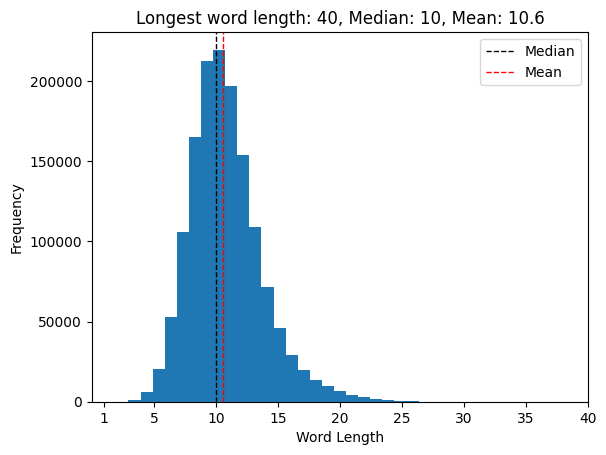

In [28]:
plot_word_lengths(words_df)

In [29]:
# Print the longest words
fourty_letter_words = words_df[words_df['word'].str.len() == 40]
print(f"Number of 40-letter words: {len(fourty_letter_words):,}")
fourty_letter_words.head()

Number of 40-letter words: 8


,word,is_main,search_count,description
687530,непротивоконституционствувателствувалият,False,3.0,мин.деят.св.прич. м.р. пълен член
687532,непротивоконституционствувателствувалата,False,3.0,мин.деят.св.прич. ж.р. членувано
687534,непротивоконституционствувателствувалото,False,3.0,мин.деят.св.прич. ср.р. членувано
687536,непротивоконституционствувателствувалите,False,3.0,мин.деят.св.прич. мн.ч. членувано
687543,непротивоконституционствувателствуващият,False,2.0,сег.деят.прич. м.р. пълен член


In [30]:
# Print the longest words
thirty_plus_letter_words = words_df[words_df['word'].str.len() >= 30]
print(f"Number of 30+ letter words: {len(thirty_plus_letter_words):,}")
thirty_plus_letter_words.head(10)

Number of 30+ letter words: 51


,word,is_main,search_count,description
687356,непротивоконституционствувателствувам,True,0.0,"сег.вр., 1л., ед.ч."
687357,непротивоконституционствувателствуваме,False,2.0,"сег.вр., 1л., мн.ч."
687358,непротивоконституционствувателствуваш,False,2.0,"сег.вр., 2л., ед.ч."
687359,непротивоконституционствувателствувате,False,3.0,"сег.вр., 2л., мн.ч."
687360,непротивоконституционствувателствува,False,5.0,"сег.вр., 3л., ед.ч."
687361,непротивоконституционствувателствуват,False,2.0,"сег.вр., 3л., мн.ч."
687362,непротивоконституционствувателствувах,False,4.0,"мин.св.вр., 1л., ед.ч."
687363,непротивоконституционствувателствувахме,False,3.0,"мин.св.вр., 1л., мн.ч."
687364,непротивоконституционствувателствува,False,0.0,"мин.св.вр., 2л., ед.ч."
687365,непротивоконституционствувателствувахте,False,3.0,"мин.св.вр., 2л., мн.ч."


In [31]:
# Print the longest words
twenty_five_plus_letter_words = words_df[(words_df['word'].str.len() >= 25) & (words_df['word'].str.len() < 30)]
print(f"Number of 25-29 letter words: {len(twenty_five_plus_letter_words):,}")
twenty_five_plus_letter_words.sample(10)

Number of 25-29 letter words: 594


,word,is_main,search_count,description
290788,дванадесетмегапикселовото,False,7.0,ср.р. членувано
106776,четиристотинмегапикселния,False,5.0,м.р. непълен член
354625,седемнадесетнанометровото,False,3.0,ср.р. членувано
372764,четиридесетмегапикселовия,False,2.0,м.р. непълен член
294750,деветнадесеткилометровите,False,4.0,мн.ч. членувано
375512,четиристотинмегахерцовата,False,4.0,ж.р. членувано
374520,четиринайсетгигабайтовият,False,1.0,м.р. пълен член
280017,шестнайсетинафиналистчета,False,2.0,мн.ч.
374214,четиринадесетнанометровият,False,1.0,м.р. пълен член
60237,общественопроизводителния,False,8.0,м.р. непълен член


In [32]:
# Print the longest words
twenty_one_plus_letter_words = words_df[(words_df['word'].str.len() >= 21) & (words_df['word'].str.len() < 25)]
print(f"Number of 21-24 letter words: {len(twenty_one_plus_letter_words):,}")
twenty_one_plus_letter_words.sample(10)

Number of 21-24 letter words: 9,750


,word,is_main,search_count,description
106749,четиристотинкомпонентния,False,5.0,м.р. непълен член
294570,деветнадесетгалоновите,False,4.0,мн.ч. членувано
341226,петнайсетмегапикселовите,False,6.0,мн.ч. членувано
90937,суперразузнавателният,False,4.0,м.р. пълен член
2018070,самоусъвършенствувана,False,0.0,мин.страд.прич. ж.р.
373441,четирийсетмилилитрова,False,4.0,ж.р.
356038,седемстотинфранковото,False,4.0,ср.р. членувано
27274,деветстотинкомпонентно,False,4.0,ср.р.
353855,седемдесеттерабитовия,False,2.0,м.р. непълен член
379193,шестнайсетмегаватовата,False,3.0,ж.р. членувано


## 16. Remove duplicates
Yes, `син` and `син` could mean different things (e.g. noun and adjective). And these would be needed for the POS tagging dataset, but current goal is to extract a flat list of words, so we don't need these duplicates.

In [33]:
# Remove duplicated words
words_df = words_df.drop_duplicates(subset=['word'])
print(f"Total words count (after removing duplicates): {len(words_df):,}")

Total words count (after removing duplicates): 1,112,236


## 17. Dump to file

We have `1 112 236` unique valid Bulgarian words. Let's dump this vocabulary to file.

In [34]:
# Sort and dump the first column of the words_df
words = words_df['word'].sort_values().tolist()
with open('data/words.txt', 'w', encoding='windows-1251') as f:
    for word in words:
        f.write(word + '\n')

# Convert to gzip
with open('data/words.txt', 'rb') as f_in:
    with gzip.open('data/words.txt.gz', 'wb') as f_out:
        f_out.writelines(f_in)
# Remove the original file
os.remove('data/words.txt')

print(f"Number of words written to file: {len(words):,}")

Number of words written to file: 1,112,236
